<a href="https://colab.research.google.com/github/r-diazp/deepL/blob/master/lstm_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#![pytorch icon.png](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQWyV5brHNCcNRsfWARFMR78N0Wg5V2hksMVYQeOpYnBn4zKOX2PPWky9wqxVoXuvnUi_s&usqp=CAU)

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [32]:
#Cargar DataSet (Data source: https://fred.stlouisfed.org/series/S4248SM144NCEN)
path = '/content/drive/MyDrive/Dataset/'
df = pd.read_csv(path + 'lstm_time_series.csv')
df.dropna(inplace=True) #Quitar valores nulos del DataFrame 
df.columns = ['date', 'target']
target = df['target'].values.astype(float)

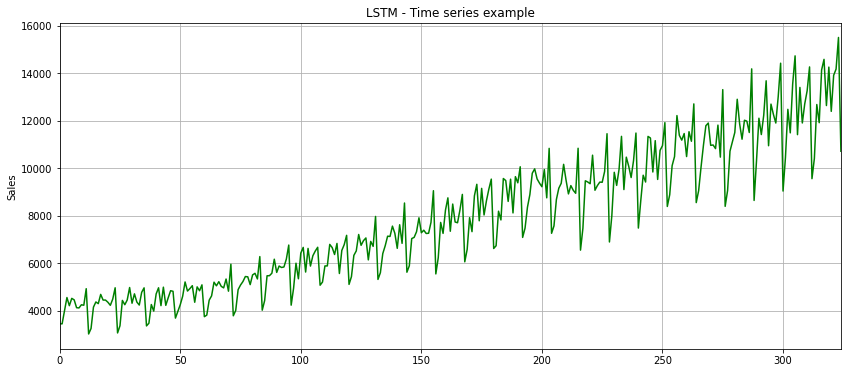

In [3]:
#Grafica del DataSet
plt.figure(figsize=(14,6))
plt.title('LSTM - Time series example')
plt.ylabel('Sales')
plt.autoscale(axis='x',tight=True)
plt.plot(df['target'], 'green')
plt.grid(True)
plt.show()

In [4]:
#Funcion determinar ventana de los tensores 
def input_data(sequence, windows_size):  #Windows_size tamaño de la ventana 
    output = []
    L = len(sequence)
    for i in range(L - windows_size):
        window = sequence[i : i + windows_size]
        label = sequence[i + windows_size : i + windows_size+1]
        output.append((window, label))
    return output

In [28]:
#PREPAR DATOS 
# Crear datos de entrnamiento y test 
test_size = 12
train_set = target[:-test_size]
test_set = target[-test_size:]

# Normalizar los datos (https://en.wikipedia.org/wiki/Feature_scaling)
scaler = MinMaxScaler(feature_range=(-1, 1))
train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

print(f'- train_norm.min = {train_norm.min()} \n- train_norm.max = {train_norm.max()} \
      \n- train_norm.mean = {train_norm.mean()} \n- train_norm type = {type(train_norm)}')

# Datos de entranmiento 
window_size = 12
train_norm = torch.FloatTensor(train_norm).view(-1) #conver train_norm en tensor 
train_data = input_data(train_norm, window_size)

- train_norm.min = -1.0 
- train_norm.max = 1.0       
- train_norm.mean = -0.2041940178388313 
- train_norm type = <class 'numpy.ndarray'>


# Arquitectura del modelo LSTM

In [6]:
class LSTM(nn.Module):
  def __init__(self, input_size=1, hidden_size=100, output_size=1):
      super().__init__()
      self.hidden_size = hidden_size
      
      # Agrear una celda LSTM :
      self.lstm = nn.LSTM(input_size,hidden_size)
      
      # Agregar una capa full connect:
      self.linear = nn.Linear(hidden_size,output_size)
      
      # Inicializar valores de h0 y c0:
      self.hidden = (torch.zeros(1,1, self.hidden_size),
                      torch.zeros(1,1, self.hidden_size))

  def forward(self,seq):
      lstm_out, self.hidden = self.lstm(
          seq.view(len(seq),1,-1), self.hidden)
      pred = self.linear(lstm_out.view(len(seq), -1))
      return pred[-1]  # Solo se requiere los ultimos valores de la ventana  

In [33]:
#Instanciamos el modelo 
torch.manual_seed(101)
model = LSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

# Entrenamiento del modelo 

Epoch:  2 Loss: 0.37531984
Epoch: 12 Loss: 0.25998449
Epoch: 22 Loss: 0.20818661
Epoch: 32 Loss: 0.01853217
Epoch: 42 Loss: 0.00153922
Epoch: 52 Loss: 0.00820533
Epoch: 62 Loss: 0.00039125
Epoch: 72 Loss: 0.00080486

Duration: 67 seconds


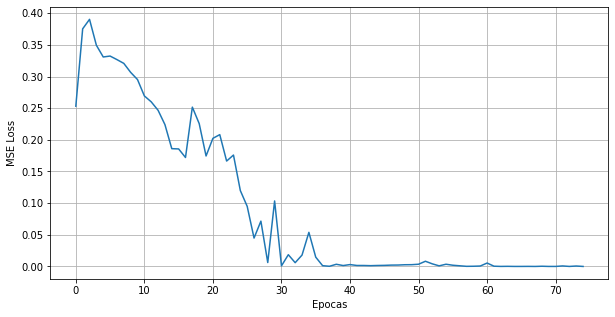

In [8]:
epochs = 75
losses = []
start_time = time.time()

for epoch in range(epochs):    
    # Extraer sequence & target de los datos de entrenamiento 
    
    for sequence, target in train_data:        
      # Resetear el estado de los parametros de la capa oculta 
      optimizer.zero_grad()
      model.hidden = (torch.zeros(1, 1, model.hidden_size),
                      torch.zeros(1, 1, model.hidden_size))
      
      #Hacer predicciones con el modelo 
      prediction = model(sequence) 
      
      #Back Propagation
      loss = criterion(prediction, target)
      loss.backward()
      optimizer.step()
    
    losses.append(loss)        
    #Imprimir resultados del entrenamiento (cada 25 epocas)
    if epoch%10 == 1: 
      print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

#Grafica de convergencia del entrenamiento
plt.figure(figsize = (10,5)) 
plt.plot(range(epochs), losses)
plt.ylabel('MSE Loss')
plt.xlabel('Epocas');
plt.grid(True)

# Evaluar resultados de entrenamiento

No handles with labels found to put in legend.


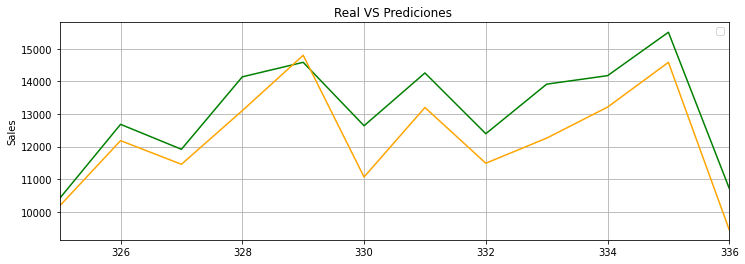

In [9]:
#Evaluar resultados de entrenamiento
future = 12 #Valor a predecir a futuro 
model.eval() # colocamos el modelo en modo de evaluacion 

# Agregar los valores de entranamiento de la ultima ventana a la lista de predicciones 
pred_test = train_norm[-window_size:].tolist()

for i in range(future):
    sequence = torch.FloatTensor(pred_test[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_size),
                        torch.zeros(1, 1, model.hidden_size))
        
        pred_test.append(model(sequence).item())

# Invertimos la normalizacion de los datos 
predictions_test = scaler.inverse_transform(np.array(pred_test[window_size:]).reshape(-1, 1) )

# Grafica comparativo Real VS Prediccion 
x = [*range(len(df.index), len(df.index) + future, 1)]
plt.figure(figsize=(12,4))
plt.title('Real VS Prediciones ')
plt.ylabel('Sales')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(x, df['target'][-12:], "green")
plt.plot(x, predictions_test[-12:], "orange")
plt.legend()
plt.show()

# Predicion de valores a futuro 

Epoch:  2 Loss: 0.30489939
Epoch: 12 Loss: 0.17739525
Epoch: 22 Loss: 0.18368724
Epoch: 32 Loss: 0.03614022
Epoch: 42 Loss: 0.02771222
Epoch: 52 Loss: 0.02962688
Epoch: 62 Loss: 0.01400772
Epoch: 72 Loss: 0.00733618
Epoch: 82 Loss: 0.01239910
Epoch: 92 Loss: 0.01163709
Epoch: 102 Loss: 0.00114254
Epoch: 112 Loss: 0.00000000
Epoch: 122 Loss: 0.00081994

Duration: 114 seconds


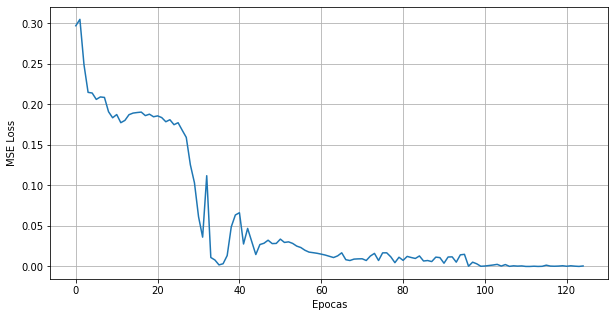

In [34]:
#ENTRENAMIENTO CON TODO LOS DATOS 
epochs = 125
losses = []
model.train() 
start_time = time.time()

# feature scale the entire dataset
target_norm = scaler.fit_transform(target.reshape(-1, 1))
target_norm = torch.FloatTensor(target_norm).view(-1)
all_data = input_data(target_norm, window_size)

for epoch in range(epochs):    
    # Extraer sequence & target de los datos de entrenamiento 
    
    for sequence, target in all_data:        
      # Resetear el estado de los parametros de la capa oculta 
      optimizer.zero_grad()
      model.hidden = (torch.zeros(1, 1, model.hidden_size),
                      torch.zeros(1, 1, model.hidden_size))
      
      #Hacer predicciones con el modelo 
      prediction = model(sequence) 
      
      #Back Propagation
      loss = criterion(prediction, target)
      loss.backward()
      optimizer.step()
    
    losses.append(loss)        
    #Imprimir resultados del entrenamiento (cada 25 epocas)
    if epoch%10 == 1: 
      print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

#Grafica de convergencia del entrenamiento
plt.figure(figsize = (10,5)) 
plt.plot(range(epochs), losses)
plt.ylabel('MSE Loss')
plt.xlabel('Epocas');
plt.grid(True)

No handles with labels found to put in legend.


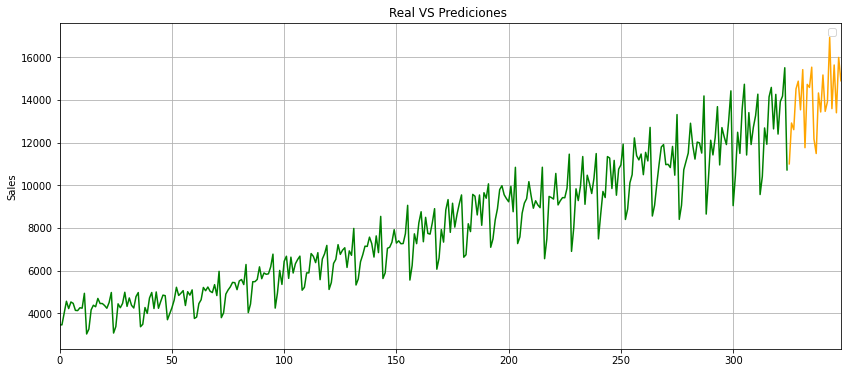

In [35]:
#Evaluar resultados de entrenamiento
future = 24 #Valor a predecir a futuro 
model.eval() # colocamos el modelo en modo de evaluacion 

# Agregar los valores de entranamiento de la ultima ventana a la lista de predicciones 
pred_test = train_norm[-window_size:].tolist()

for i in range(future):
    sequence = torch.FloatTensor(pred_test[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_size),
                        torch.zeros(1, 1, model.hidden_size))
        
        pred_test.append(model(sequence).item())

# Invertimos la normalizacion de los datos 
predictions_test = scaler.inverse_transform(np.array(pred_test[window_size:]).reshape(-1, 1) )

# Grafica comparativo Real VS Prediccion 
x = [*range(len(df.index), len(df.index) + future, 1)]
plt.figure(figsize=(14,6))
plt.title('Real VS Prediciones ')
plt.ylabel('Sales')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['target'], "green")
plt.plot(x, predictions_test, "orange")
plt.legend()
plt.show()